In [1]:
import numpy as np
import pandas as pd
import random
import math
import os
import datetime
import sys
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

%matplotlib inline

Using TensorFlow backend.


In [2]:
prediction_len = 200
train_test_ratio = 0.9
batch_size = 250
file_name = 'data/yah_stocks/EA.csv'

In [3]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [(p / window[0] - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def transform_data(data, seq_len, normalise_window):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(train_test_ratio * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

#     x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
#     x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

In [4]:
data = pd.read_csv(file_name)
data = data[['Open', 'High', 'Low', 'Close']]

In [5]:
X_train, y_train, X_test, y_test = transform_data(data.as_matrix(), prediction_len, True)

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3729, 200, 4)
(3729, 4)
(414, 200, 4)
(414, 4)


In [7]:
model = Sequential()

model.add(LSTM(128, input_dim = 4, input_length=prediction_len, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(output_dim=4))
model.add(Activation('linear'))

model.compile(loss='mse', optimizer='rmsprop')

In [8]:
model.fit(X_train,
    y_train,
    batch_size=512,
    nb_epoch=5,
    validation_split=0.05)

Train on 3542 samples, validate on 187 samples
Epoch 1/5
3542/3542 [==============================] - 32s - loss: 0.0956 - val_loss: 0.0217
Epoch 2/5
3542/3542 [==============================] - 34s - loss: 0.0242 - val_loss: 0.0101
Epoch 3/5
3542/3542 [==============================] - 33s - loss: 0.0192 - val_loss: 0.0098
Epoch 4/5
3542/3542 [==============================] - 33s - loss: 0.0151 - val_loss: 0.0080
Epoch 5/5
3542/3542 [==============================] - 36s - loss: 0.0150 - val_loss: 0.0084


In [9]:
predictions = model.predict(X_test, batch_size=512)

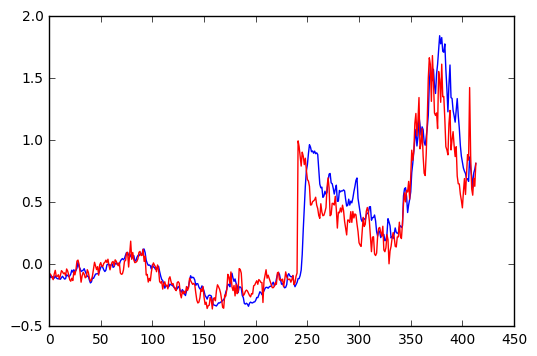

In [38]:
plt.plot(predictions[:, 0], c='b')
plt.plot(y_test[:, 0], c='r')
plt.show()

In [40]:
 - 

0.039391655177651884

In [44]:
sgn1 = np.array([1 if predictions[:,0][i] - predictions[:,0][i-1] > 0 else -1 for i in range(1,len(predictions[:, 0]))])
sgn2 = np.array([1 if y_test[:,0][i] - y_test[:,0][i-1] > 0 else -1 for i in range(1,len(y_test[:, 0]))])

In [48]:
abs((sgn1 - sgn2) / 2).mean()

0.39467312348668282